In [51]:
## Creates pointclouds and vectorizations of persistence diagrams from the ModelNet dataset.
import sys

#import pandas as pd
from copy import deepcopy
import numpy as np
import gudhi as gd
import argparse
import os
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import trimesh as trm
import glob


import tensorflow as tf
import tensorflow.keras as keras
from utils import DenseRagged, PermopRagged
from utils import sep_dist, measure_dist
from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances

from tensorflow.keras.regularizers import l1, l2

import mtd
import numpy as np
from scipy.stats import entropy

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec


import seaborn as sns

# sns.set_theme(style="darkgrid")
FIG_SIZE = (18,5)
sns.set_context("talk")

In [5]:
data_dir = "Data/ModelNet10/"
num_samples=1024
sample_even=False
normalize=True
global_bounding_box=False

In [10]:
file_structure = glob.glob(f"{data_dir}/**",recursive=False)
labels = [name.split("/")[-1] for name in file_structure]

In [14]:
test_dir  = [os.path.join(name, 'test') for name in file_structure]
train_dir = [os.path.join(name, 'train') for name in file_structure]

all_train_files = [os.listdir(name) for name in train_dir]
all_test_files  = [os.listdir(name) for name in test_dir]
N_train     = len(all_train_files)
N_test      = len(all_test_files)

In [30]:
## Loading the mesh data and creating the point clouds:
def create_pointclouds(list_files, directory, num_samples,
                       normalize=normalize, sample_even=sample_even,
                       choice_train=True):
    sample_fct = trm.sample.sample_surface
    if sample_even:
        sample_fct = trm.sample.sample_surface_even

    pcs = []
    # if choice_train:
    #     cur_dir = train_dir
    # else:
    #     cur_dir = test_dir

    for file in tqdm(list_files, desc=f'creating PCs for {directory.split("/")[-2]}'):
        mesh = trm.load(os.path.join(directory, file))
        pc = sample_fct(mesh, num_samples)[0]
        np.random.shuffle(pc)
        assert(pc.shape == (num_samples, 3) or sample_even)
        if normalize:
            pc -= np.mean(pc, axis=0, dtype=np.float64)
            MX = np.max(np.linalg.norm(pc, axis=1))
            pc /= MX
        pcs.append(pc)
    return pcs

# if dataset_choice != 'test':
#     pc_train = create_pointclouds(list_files=train_files, num_samples=num_samples, dataset_choice=dataset_choice,
#                                   sample_even=sample_even, choice_train=True)
# else:
#     pc_train = []
# pc_test = create_pointclouds(list_files=test_files, num_samples=num_samples, dataset_choice=dataset_choice,
#                              sample_even=sample_even, choice_train=False)

# pc_test_clean = []
# ## Add noise if dataset_choice == 'test'
# if (dataset_choice == 'test' and N_noise > 0):
#     pc_test_clean = deepcopy(pc_test)
#     if not global_bounding_box:
#         for pc in pc_test:
#             rand_x = np.random.uniform(low=np.min(pc[:, 0]), high=np.max(pc[:, 0]), size=int(N_noise))
#             rand_y = np.random.uniform(low=np.min(pc[:, 1]), high=np.max(pc[:, 1]), size=int(N_noise))
#             rand_z = np.random.uniform(low=np.min(pc[:, 2]), high=np.max(pc[:, 2]), size=int(N_noise))
#             rand = np.stack((rand_x, rand_y, rand_z), axis = 1)

#             noise_idxs = np.random.choice(np.arange(num_samples), size=N_noise, replace=False)
#             pc[noise_idxs] = rand

In [34]:
pc_train = []
for class_ind in range(len(train_dir)):
    pcs = create_pointclouds(list_files=all_train_files[class_ind], directory = train_dir[class_ind], num_samples=num_samples,
                                      sample_even=sample_even, choice_train=True)
    pc_train = pc_train + pcs

creating PCs for dresser: 100%|███████████████| 200/200 [00:18<00:00, 10.90it/s]


In [43]:
buffer = np.array([[i, j] for i in np.arange(len(pc_train)) for j in np.arange(len(pc_train))])
buffer_id =  np.random.choice(len(buffer), 2500, replace = False)
train_indexes = buffer[buffer_id]

In [ ]:
n_boostrap = 30
train_PD = []
for i,j in tqdm(train_indexes):  
    barc = [mtd.calc_cross_barcodes(pc_train[i], pc_train[j], batch_size1 = 600, batch_size2 = 700, is_plot = False, pdist_device = "cuda") for _ in range(n_boostrap)]
    train_PD.append(barc)

  3%|█▏                                    | 77/2500 [22:34<11:37:58, 17.28s/it]

In [56]:
# import pickle
# with open("Data/cross_ripsnet_3d_exp/3d_shapes_indexes_2500_30_boostrap", "wb") as fp:   #Pickling
#     pickle.dump(train_indexes, fp)

In [ ]:
# import pickle
# with open("Data/cross_ripsnet_3d_exp/3d_shapes_pds_2500_30_boostrap", "wb") as fp:   #Pickling
#     pickle.dump(train_PD, fp)

In [47]:
train_PD_1 = [[x[1] if len(x[1])>0 else np.array([[0., 0.]]) for x in barcs ] for barcs in train_PD]

In [52]:
pds_train = DiagramSelector(use=True).fit_transform(train_PD_1[0])
vpdtr = np.vstack(pds_train)

for barcs in train_PD_1[1:]:
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    vpdtr = np.vstack((vpdtr, np.vstack(pds_train)))

pers = vpdtr[:,1]-vpdtr[:,0]
bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
sigma = np.quantile(ppers, .2)
im_bnds = [np.quantile(vpdtr[:,0],0.2), np.quantile(vpdtr[:,0],0.8), np.quantile(pers,0.2), np.quantile(pers,0.8)]

In [53]:
from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances
from gudhi.representations import  PersistenceImage

PI_train_all = []
for barcs in train_PD_1:
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    # clean_pds_test = DiagramSelector(use=True).fit_transform(train_PD_1[800:])
    
    
    # vpdtr = np.vstack(pds_train)
    # pers = vpdtr[:,1]-vpdtr[:,0]
    # bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
    # ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
    # sigma = np.quantile(ppers, .2)
    # im_bnds = [np.quantile(vpdtr[:,0],0.2), np.quantile(vpdtr[:,0],0.8), np.quantile(pers,0.2), np.quantile(pers,0.8)]
    # # im_bnds = [0, 1, 0, np.quantile(pers,1.)]
    # # sp_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,1],1.)]
    
    
    PI_params = {'bandwidth': sigma, 'weight': lambda x: x[1]**3, 
                 'resolution': [50,50], 'im_range': im_bnds}
    PI_train = PersistenceImage(**PI_params).fit_transform(pds_train)
    # clean_PI_test = PersistenceImage(**PI_params).fit_transform(clean_pds_test)
    PI_train = np.sum(PI_train,axis = 0)/n_boostrap
    PI_train = PI_train/np.sum(PI_train)
    PI_train_all.append(PI_train)
    
PI_train_all = np.array(PI_train_all)

In [54]:
PI_train = np.vstack([PI_train_all[:2200]])
clean_PI_test = np.vstack([PI_train_all[2200:]])

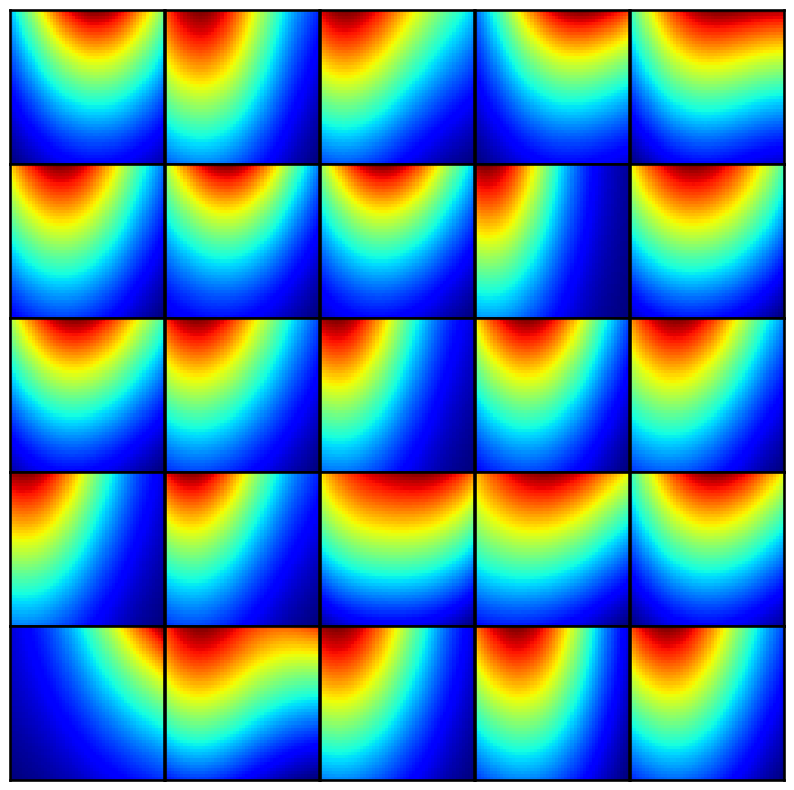

In [55]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(5, 5, width_ratios=[1,1,1,1,1], wspace=0.0, hspace=0.0)
for i in range(5):
    for j in range(5):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(PI_train[200*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])

In [74]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                            patience=300, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=False)

optim = tf.keras.optimizers.Adamax(learning_rate=5e-4)
inputs_1 = tf.keras.Input(shape=(None,3), dtype ="float32", ragged=True)
inputs_2 = tf.keras.Input(shape=(None,3), dtype ="float32", ragged=True)

x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_1)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)

y = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_2)
y = DenseRagged(units=20, use_bias=True, activation='relu')(y)
y = DenseRagged(units=10, use_bias=True, activation='relu')(y)
y = PermopRagged()(y)

x_y = keras.layers.Concatenate(axis=1)([inputs_1, inputs_2])
x_y = DenseRagged(units=30, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=20, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=10, use_bias=True, activation='relu')(x_y)
x_y= PermopRagged()(x_y)
## Добавить расстояния как фичи


z = keras.layers.Concatenate(axis=-1)([x, y, x_y])

z = tf.keras.layers.Dense(100,  activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
# z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
# z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=l2(1e-3), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(0.5)(z)
outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(z)
outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)
model_PI_second_type = tf.keras.Model(inputs=[inputs_1,inputs_2], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss="kl_divergence")

In [64]:
data_train_concat = np.array([np.vstack((pc_train[i],pc_train[j])) for i,j in train_indexes[:2200]])
data_test_concat = np.array([np.vstack((pc_train[i],pc_train[j])) for i,j in train_indexes[2200:]])


tf_data_train_1 = tf.ragged.constant([
    [list(c) for c in list(data_train_concat[i, :num_samples])] for i in range(len(data_train_concat))], ragged_rank=1)
tf_data_train_2 = tf.ragged.constant([
    [list(c) for c in list(data_train_concat[i, num_samples:])] for i in range(len(data_train_concat))], ragged_rank=1)


tf_data_test_1 = tf.ragged.constant([
    [list(c) for c in list(data_test_concat[i, :num_samples])] for i in range(len(data_test_concat))], ragged_rank=1)
tf_data_test_2 = tf.ragged.constant([
    [list(c) for c in list(data_test_concat[i, num_samples:])] for i in range(len(data_test_concat))], ragged_rank=1)

In [75]:
history = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2], PI_train, epochs=2000, 
                       validation_data=([tf_data_test_1, tf_data_test_2], clean_PI_test), callbacks=[callback], verbose=1)

Epoch 1/2000
69/69 [==============================] - 3s 24ms/step - loss: 248.2164 - val_loss: 87.0201
Epoch 2/2000
69/69 [==============================] - 1s 15ms/step - loss: 41.0494 - val_loss: 12.0480
Epoch 3/2000
69/69 [==============================] - 1s 14ms/step - loss: 4.4459 - val_loss: 0.7134
Epoch 4/2000
69/69 [==============================] - 1s 13ms/step - loss: 0.3072 - val_loss: 0.1953
Epoch 5/2000
69/69 [==============================] - 1s 15ms/step - loss: 0.1776 - val_loss: 0.1708
Epoch 6/2000
69/69 [==============================] - 1s 14ms/step - loss: 0.1608 - val_loss: 0.1591
Epoch 7/2000
69/69 [==============================] - 1s 15ms/step - loss: 0.1524 - val_loss: 0.1535
Epoch 8/2000
69/69 [==============================] - 1s 15ms/step - loss: 0.1485 - val_loss: 0.1492
Epoch 9/2000
69/69 [==============================] - 1s 15ms/step - loss: 0.1446 - val_loss: 0.1467
Epoch 10/2000
69/69 [==============================] - 1s 14ms/step - loss: 0.1422 - v

In [76]:
train_PI_prediction = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2])
clean_PI_prediction = model_PI_second_type.predict([tf_data_test_1, tf_data_test_2])

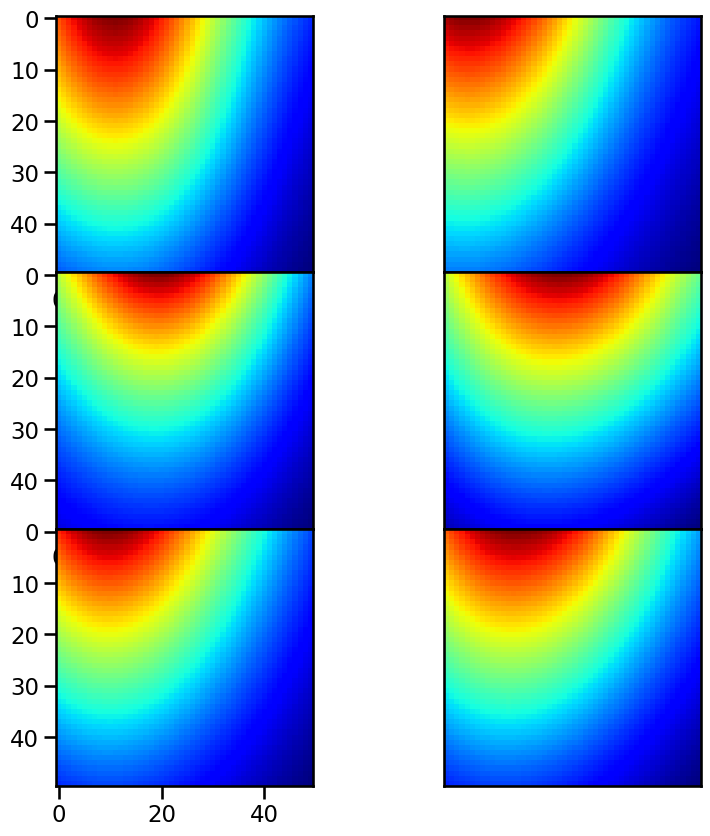

In [77]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(PI_train[200*i+1], [50,50]), 0), cmap='jet')

    ax = plt.subplot(gs[i,1])
    ax.imshow(np.flip(np.reshape(train_PI_prediction[200*i+1], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])

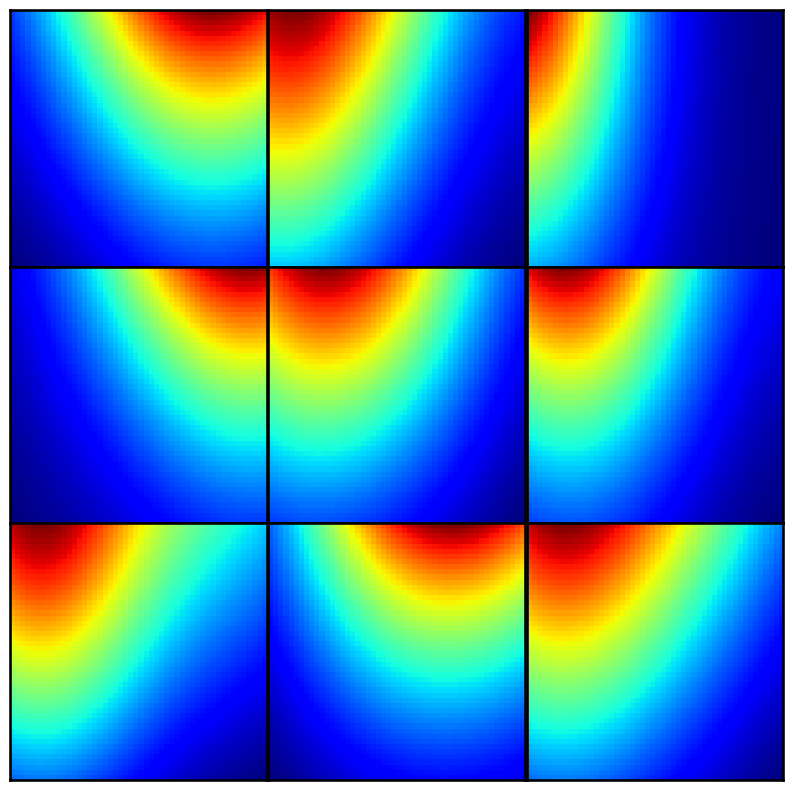

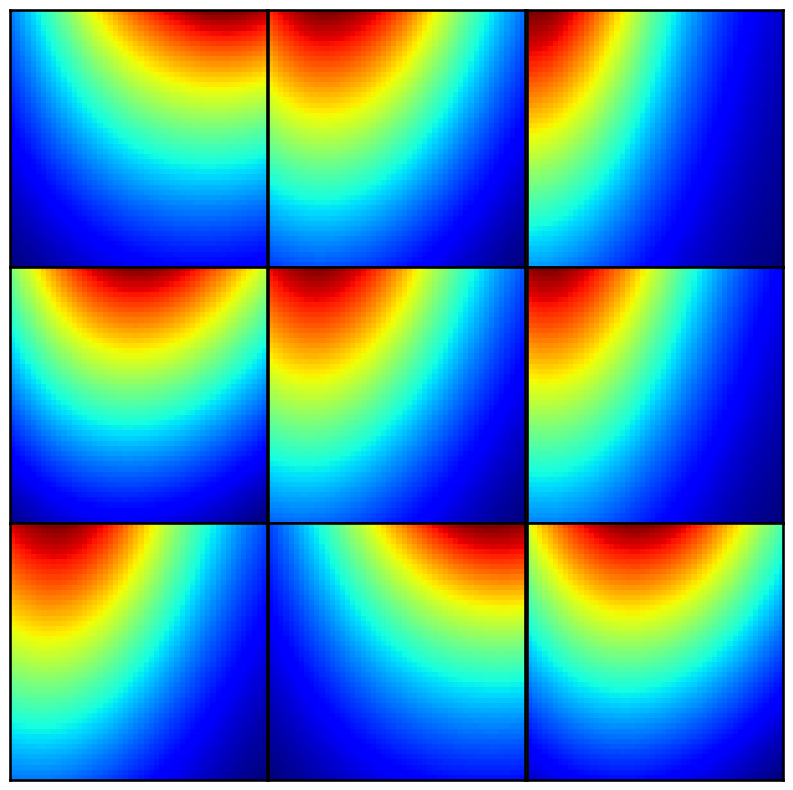

In [78]:
# fig = plt.figure(figsize=(10, 10)) 
# gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
# for i in range(3):
#     for j in range(3):
#         ax = plt.subplot(gs[i,j])
#         ax.scatter(tf_data_test_1[200*i+j,:,0], tf_data_test_1[200*i+j,:,1], s=3)
#         ax.scatter(tf_data_test_2[200*i+j,:,0], tf_data_test_2[200*i+j,:,1], s=3)
#         plt.xticks([])
#         plt.yticks([])
# # plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_test[20*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_gudhi_pi.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_prediction[20*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_ripsnet_pi.png', bbox_inches='tight')

In [ ]:
distances = measure_dist(clean_PI_test, clean_PI_prediction, method="KL")
plt.hist(distances)
plt.show()

### Let's check the model with distance matrix

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                            patience=300, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=False)

optim = tf.keras.optimizers.Adamax(learning_rate=5e-4)
inputs_1 = tf.keras.Input(shape=(None,3), dtype ="float32", ragged=True)
inputs_2 = tf.keras.Input(shape=(None,3), dtype ="float32", ragged=True)
inputs_dist = tf.keras.Input(shape=(N_points, 300), dtype ="float32", ragged=False)

x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_1)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)

y = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_2)
y = DenseRagged(units=20, use_bias=True, activation='relu')(y)
y = DenseRagged(units=10, use_bias=True, activation='relu')(y)
y = PermopRagged()(y)

x_y = keras.layers.Concatenate(axis=1)([inputs_1, inputs_2])
x_y = DenseRagged(units=30, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=20, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=10, use_bias=True, activation='relu')(x_y)
x_y= PermopRagged()(x_y)

d = DenseRagged(units=60, use_bias=True, activation='relu')(inputs_dist)
d = DenseRagged(units=40, use_bias=True, activation='relu')(d)
d = DenseRagged(units=30, use_bias=True, activation='relu')(d)
d = PermopRagged()(d)


z = keras.layers.Concatenate(axis=-1)([x, y, x_y, d])

# z = keras.layers.Concatenate(axis=-1)([x, y, x_y])

z = tf.keras.layers.Dense(150,  activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
# z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
# z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=l2(1e-3), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(0.5)(z)
outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(z)
outputs = tf.keras.layers.Lambda(lambda x: tf.experimental.numpy.clip(x, 1e-8, None))(outputs) ## for preventiong calculating log(0)
outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)
model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
# model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss="kl_divergence")